In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewnorm
from scipy import optimize
import asymNdimPdf as apdf

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [3]:
cov = [
    [ 1.0000, -0.5831,  0.3043, -0.0947],
    [-0.5831,  1.0000, -0.8086,  0.3408],
    [ 0.3043, -0.8086,  1.0000, -0.6537],
    [-0.0947,  0.3408, -0.6537,  1.0000],
]

In [4]:
measList = np.abs(np.array([
    [294294486.30765355, 13772753.716775, 13772753.71677],
    [1422794304.2929785, 24824720.888811827, 24824720.888811827],
    [1267269574.642189 , 25123416.917518854, 25123416.917518854],
    [189906179.52377066, 12954766.704744637, 12954766.704744607],
]))/1e6

In [5]:
snParams = []
for m in measList:
    #snParams.append(apdf.paramFromMeas(m[0], m[2], m[1]))
    snParams.append([m[0], m[2], 0])
    print(snParams[-1])

[294.29448630765353, 13.772753716770001, 0]
[1422.7943042929785, 24.824720888811825, 0]
[1267.2695746421891, 25.123416917518853, 0]
[189.90617952377065, 12.954766704744607, 0]


In [7]:
# N-dim PDF
loc, scale, alpha = [], [], []
for p in snParams:
    loc.append(p[0])
    scale.append(p[1])
    alpha.append(p[2])

ndSN = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov, alpha=alpha)

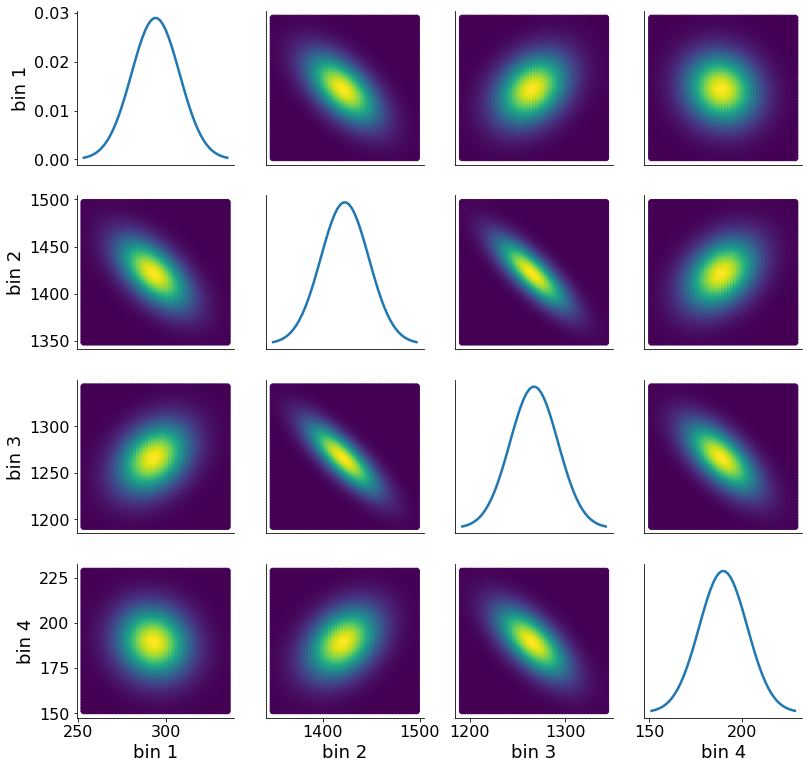

In [8]:
# Plotting each variable pair
varName = ['bin 1', 'bin 2', 'bin 3', 'bin 4']
ndSN.plot(varNames=varName, contour=False)

In [9]:
dataG = ndSN.generateDataFromGauss(N=200000, sigmaScale=6)

In [10]:
w = np.array([-0.75, -0.25, 0.25, 0.75])
CkkG = -9 * np.sum(dataG*w, axis=1) / np.sum(dataG, axis=1)

In [11]:
alpha, loc, scale = skewnorm.fit(CkkG)

In [12]:
locG, scaleG = stats.norm.fit(CkkG)

0.3321  -0.0312  +0.0313
0.3322  -0.0315  +0.0315
0.3245326781773185 0.032380222362396446 0.3116038635239807


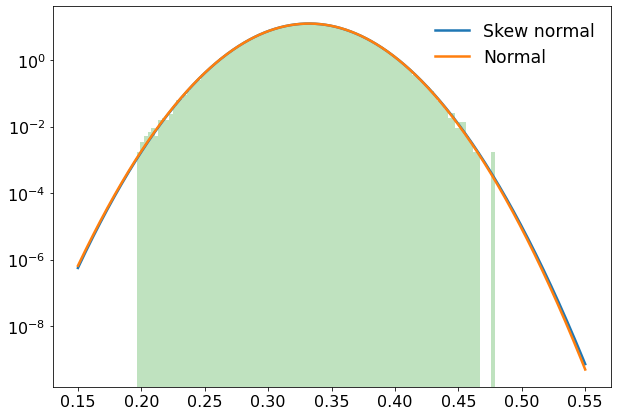

In [13]:
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
ga = stats.norm(loc=locG, scale=scaleG).pdf
x = np.linspace(0.15, 0.55, 1000)
plt.plot(x, sn.pdf(x), label='Skew normal')
plt.plot(x, ga(x), label='Normal')
plt.hist(CkkG, bins=100, density=True, alpha=0.3, log=True)
plt.legend();
print('{:.4f}  -{:.4f}  +{:.4f}'.format(*sn.measAsymError()))
print('{:.4f}  -{:.4f}  +{:.4f}'.format(locG, scaleG, scaleG))
print(loc, scale, alpha)

In [14]:
dataL = []
for i in range(10):
    dataL.append(apdf.generateData(ndSN.pdf, n=9000000, borders=ndSN.borders(4)))
data = np.concatenate(dataL)
print(data.shape)

(271360, 4)


In [15]:
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(data*w, axis=1) / np.sum(data, axis=1)

In [16]:
alpha, loc, scale = skewnorm.fit(Ckk)

0.3324  -0.0315  +0.0313


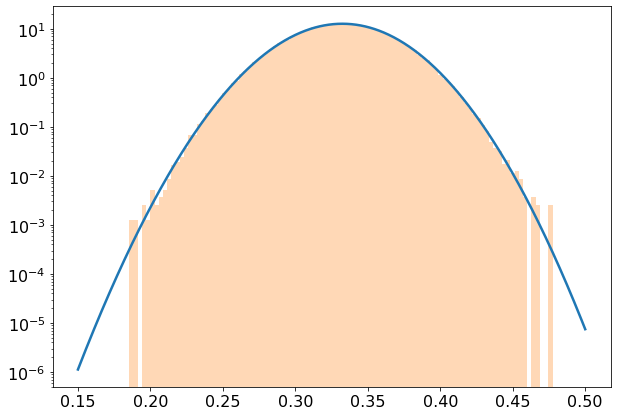

In [17]:
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
x = np.linspace(0.15, 0.5, 1000)
plt.plot(x, sn.pdf(x))
plt.hist(Ckk, bins=100, density=True, alpha=0.3, log=True);
print('{:.4f}  -{:.4f}  +{:.4f}'.format(*sn.measAsymError()))

### Generating with log and weight

In [18]:
borders=ndSN.borders(5)
print(borders)

[[ 225.81234345  362.77662263]
 [1299.35880261 1546.2301967 ]
 [1142.34847678 1392.19027708]
 [ 125.4914085   254.32113749]]


In [19]:
dLog, wLog = apdf.generateDataLog(ndSN.pdf, n=10000000, borders=ndSN.borders(10))

In [20]:
w = np.array([-0.75, -0.25, 0.25, 0.75])
CkkLog = -9 * np.sum(dLog*w, axis=1) / np.sum(dLog, axis=1)

In [21]:
def fitWeightedDistribution(data, weights, nbins=100):

    # Weighted histogram
    Nbins    = nbins
    bins     = np.linspace(data.min(), data.max(), Nbins)
    ydata, _ = np.histogram(data, weights=weights, bins=bins, density=True)

    # Bin center as x data
    xdata = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    # Loss function
    def loss(x):
        l, s, a = x
        f = apdf.ndimSkewNormal(loc=l, scale=s, alpha=a).pdf
        w = np.sqrt(np.abs(xdata - xdata.mean()))
        w = w/w.max()
        dy2 = (ydata - f(xdata))**2
        return np.sum(dy2*w)

    l0 = np.average(data, weights=weights) 
    s0 = np.sqrt( np.average((CkkLog-l0)**2, weights=weights) )
    a0 = 0

    res = optimize.minimize(loss, tol=1e-6, x0=[l0, s0, a0], method='Nelder-Mead')
    loc, scale, alpha = res.x
    
    return loc, scale, alpha

0.3322  0.0315  0.0315


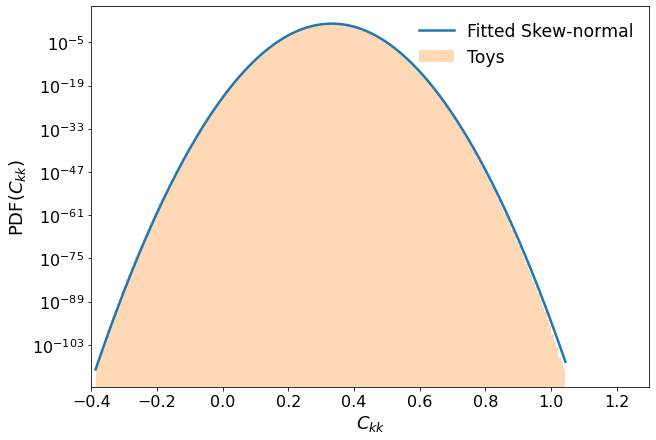

In [30]:
loc, scale, alpha = fitWeightedDistribution(CkkLog, wLog, 200)
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
x = np.linspace(CkkLog.min(), CkkLog.max(), 1000)
plt.plot(x, sn.pdf(x), label='Fitted Skew-normal')
plt.hist(CkkLog, weights=wLog, bins=200, density=True, alpha=0.3, log=True, label='Toys')
plt.xlabel('$C_{kk}$')
plt.ylabel('PDF($C_{kk}$)')
plt.xlim(-0.4, 1.3)
plt.legend()
print('{:.4f}  {:.4f}  {:.4f}'.format(*sn.measAsymError()))

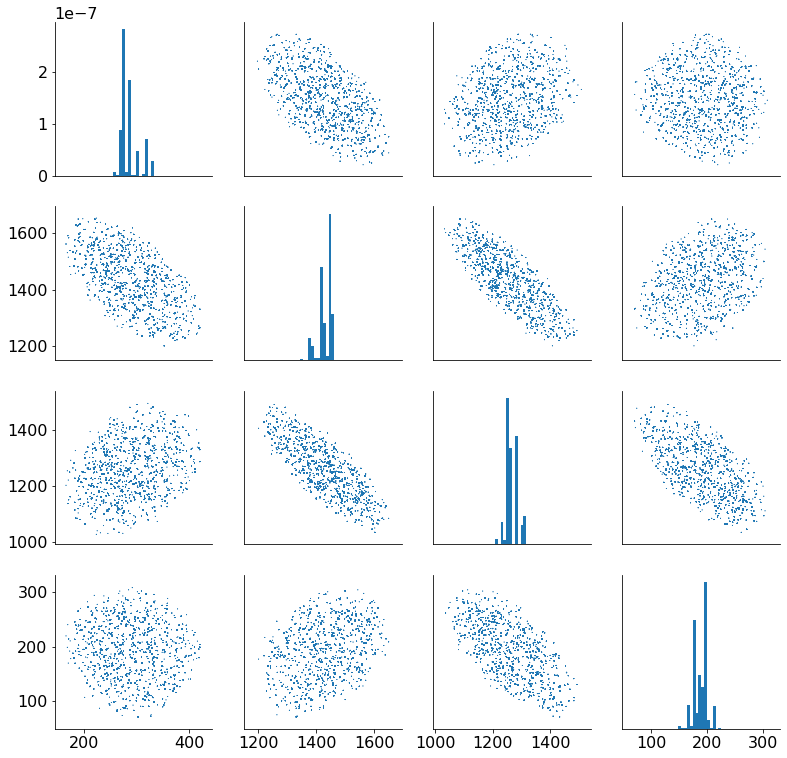

In [27]:
apdf.plotScatterMatrix(
    dLog[::1000], nPoints=-1, 
    kwargs_hist={'weights': wLog[::1000], 'bins': 50}, 
    kwargs_scatter={'s': wLog[::1000]}, )

0.3322  -0.0316  +0.0316


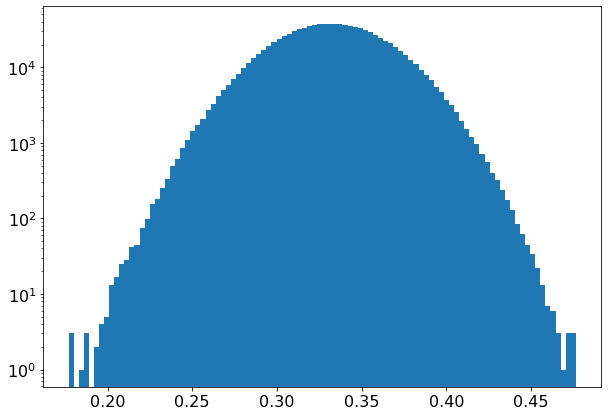

In [23]:
loc, scale = [], []
for m in measList:
    loc.append(m[0])
    scale.append(m[1])

covM = np.zeros(shape=(4, 4))
for i in range(4):
    for j in range(4):
        s1, s2 = scale[i], scale[j]
        covM[i][j] = cov[i][j] * s1 * s2

data = np.random.multivariate_normal(mean=loc, cov=covM, size=1000000)
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(data*w, axis=1) / np.sum(data, axis=1)
locG, scaleG = stats.norm.fit(Ckk)
plt.hist(Ckk, bins=100, log=True);
print('{:.4f}  -{:.4f}  +{:.4f}'.format(locG, scaleG, scaleG))